In [2]:
import sys
sys.path.append('../')

from low_rank_rnns.modules import *
from low_rank_rnns import TF, TFD, stats, plotting as plot, helpers, rankone, ranktwo, clustering

from matplotlib import pyplot as plt


In [3]:
size = 100
noise_std = 5e-2
alpha = .2
lr = 1e-2

# TF interruption analysis

In [6]:
# load a low-rank RNN

x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TF.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=4)
net_lo.load_state_dict(torch.load(f'../models/TF_rank4_{size}.pt', map_location='cpu'))

loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.039, acc=1.000


In [7]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()


# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()


wo = net_lo.wo.detach().squeeze().numpy()

In [8]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TF.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.039, acc=1.000


(844, 100)


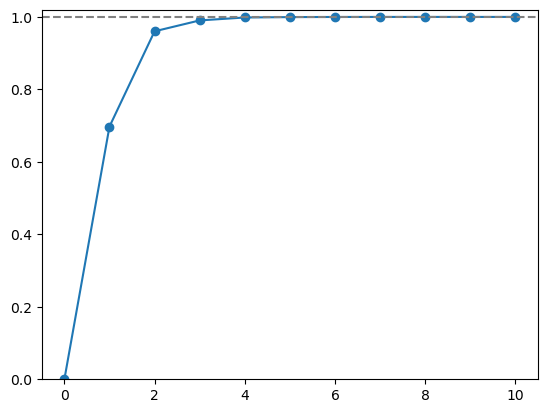

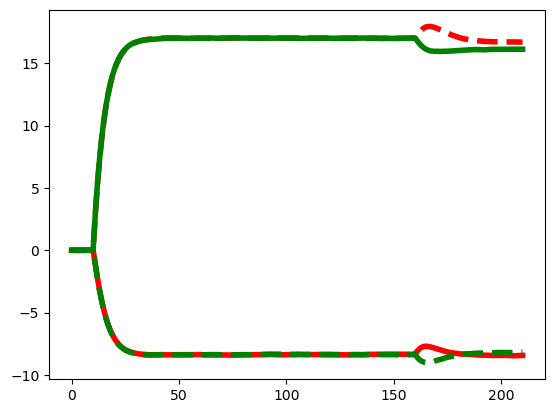

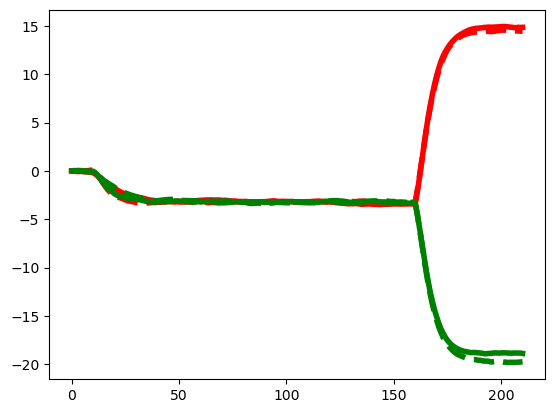

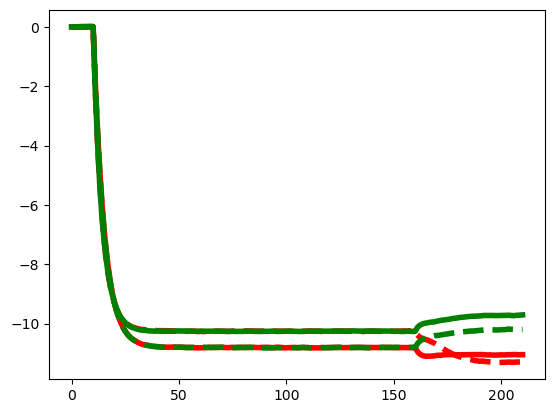

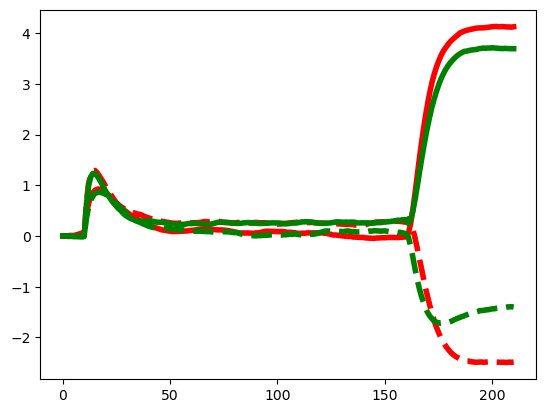

In [9]:
# low rank RNN pca
TOn = 10
COn = 160

pca = plot.pca_cumvar(trajLow, n_components=10)
plt.ylim(0, 1.02)
plt.axhline(1, ls='--', c='gray')
plt.show()

labels = ['RL', 'RR', 'GL', 'GR']
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']

ax1 = pca.components_[0]
ax2 = pca.components_[1]
ax3 = pca.components_[2]
ax4 = pca.components_[3]

k1 = trajLow @ ax1
k2 = trajLow @ ax2
k3 = trajLow @ ax3
k4 = trajLow @ ax4

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
    plt.plot(k2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k3[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(k4[i], c=colors[i], lw=4, ls = lineStyle[i], label=labels[i])
plt.show()

# # 3D pca plot
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for i in range(4):
#     plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
#     ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c='black',
#             marker='.', s=400)
#     ax.scatter(k1[i, COn], k2[i, COn], k4[i, COn], c= 'magenta',
#             marker='.', s=400)

# # ax.view_init(elev=38, azim=90)
# plt.show()

<IPython.core.display.Javascript object>


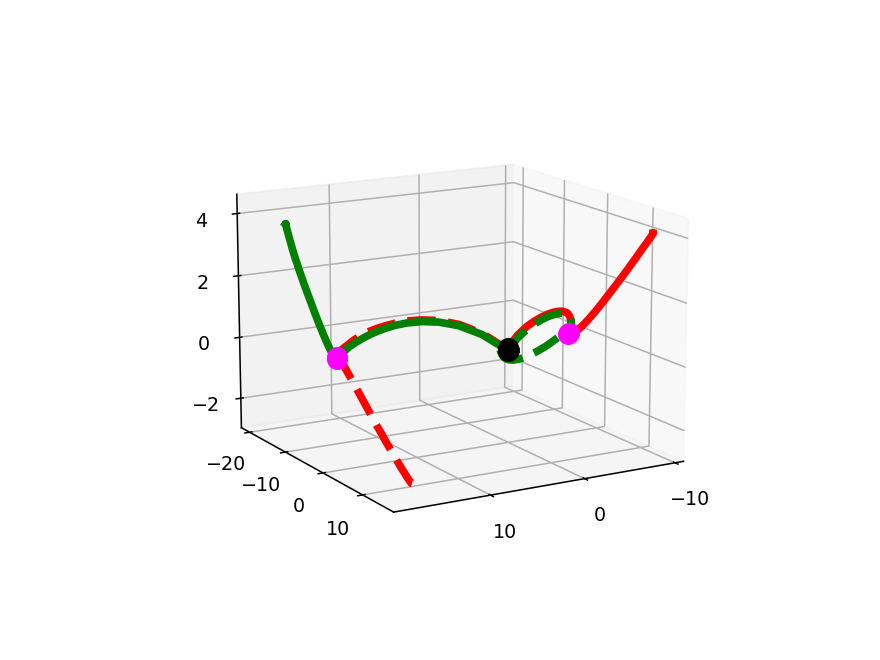

In [10]:
%matplotlib notebook

# 3D pca plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(4):
    plt.plot(k1[i], k2[i], k4[i], c=colors[i], lw=4, ls = lineStyle[i])
    ax.scatter(k1[i, TOn], k2[i, TOn], k4[i, TOn], c='black',
            marker='.', s=400)
    ax.scatter(k1[i, COn], k2[i, COn], k4[i, COn], c= 'magenta',
            marker='.', s=400)

ax.view_init(elev=14, azim=60)
plt.show()
# plt.savefig('./TFpca.pdf', bbox_inches='tight')

<IPython.core.display.Javascript object>


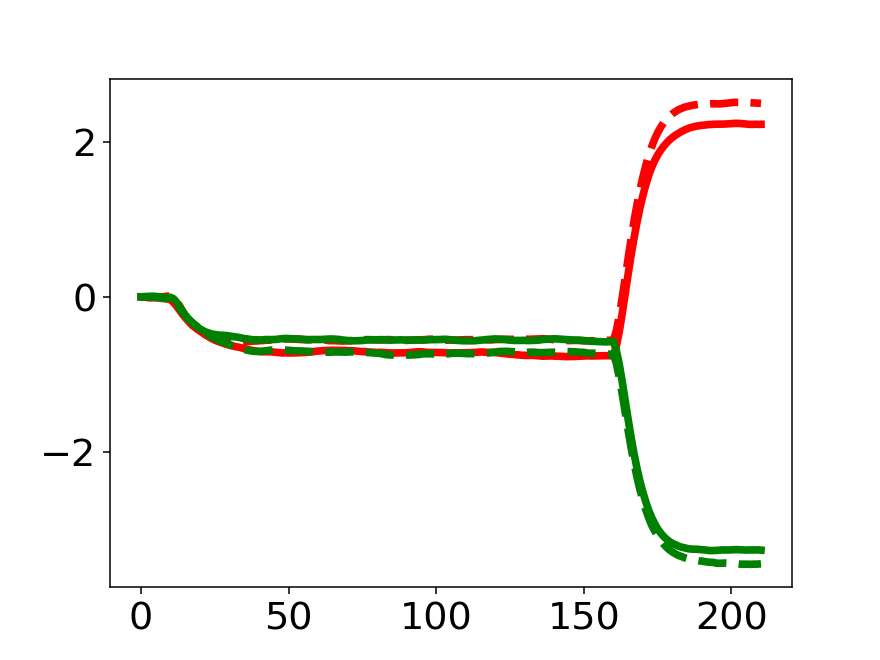

<IPython.core.display.Javascript object>


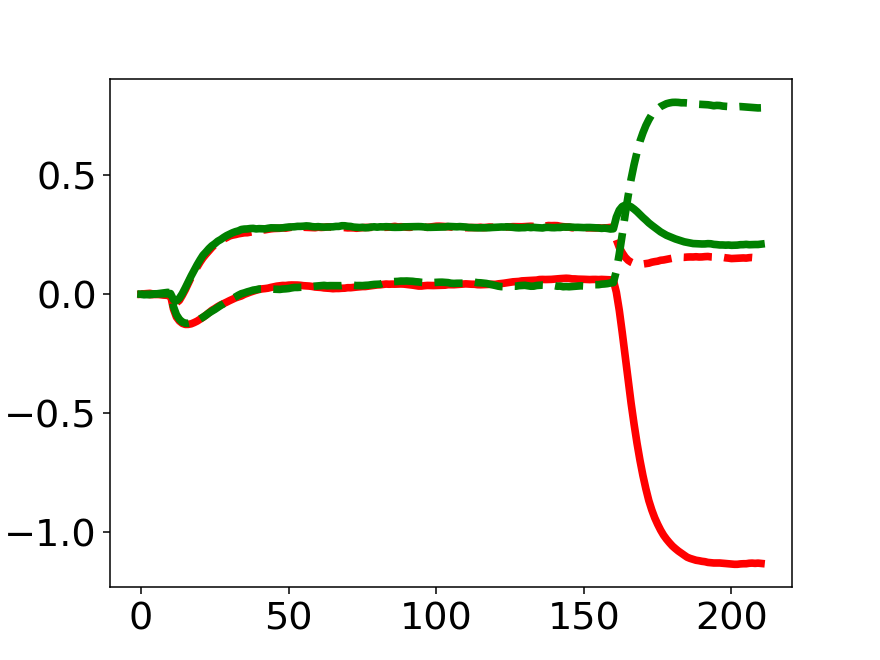

<IPython.core.display.Javascript object>


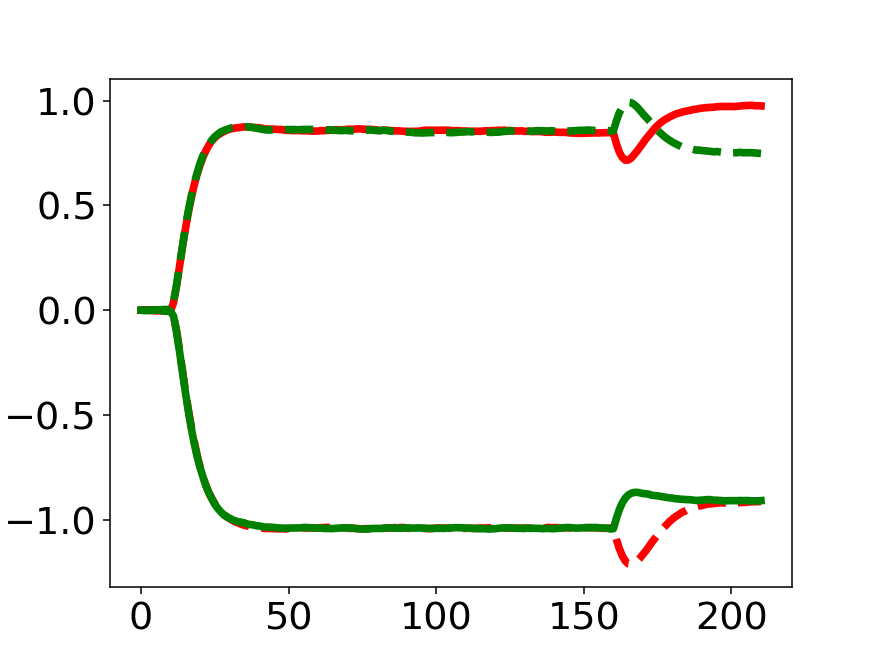

<IPython.core.display.Javascript object>


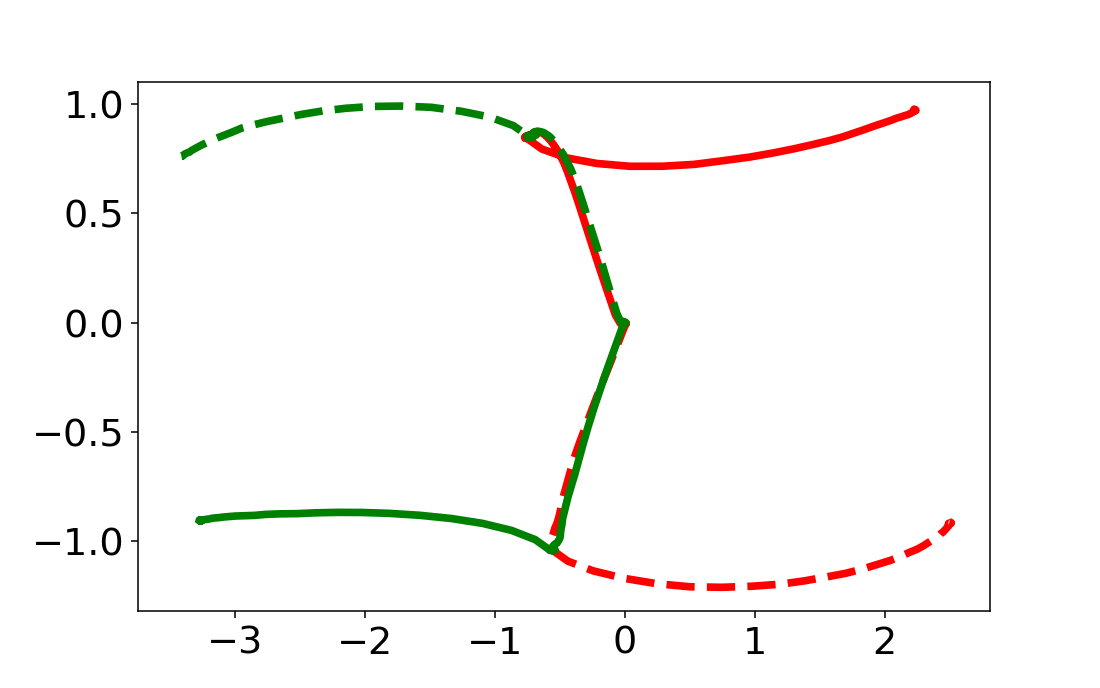

In [32]:
TOn = 10
COn = 150
# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size


colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']

plt.figure()
for i in range(4):
    plt.plot(kap1[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap2[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.figure()
for i in range(4):
    plt.plot(kap3[i], c=colors[i], lw=4, ls=lineStyle[i])
plt.show()

plt.subplots(figsize=(8,5))
colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
for i in range(4):
#      plt.plot(kap1[i], kap2[i], c=colors[i], lw=4, ls = lineStyle[i])
     plt.plot(kap1[i], kap3[i], c=colors[i], lw=4, ls=lineStyle[i])


<IPython.core.display.Javascript object>


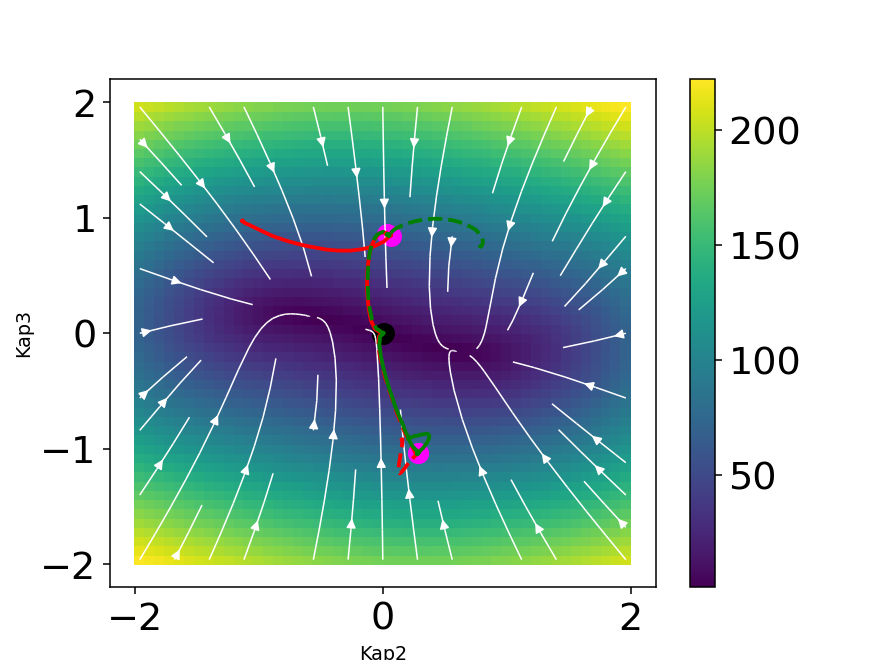

In [37]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m2, m3, -2, 2, -2, 2)
for i in range(4):
     plt.plot(kap2[i], kap3[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap2[i, TOn], kap3[i, TOn], c= 'black',
            marker='.', s=400)  
     plt.scatter(kap2[i, COn], kap3[i, COn], c= 'magenta',
            marker='.', s=400)    
plt.xlabel('Kap2')
plt.ylabel('Kap3')

plt.colorbar(mappable)

plt.show()

# plt.savefig('TFtrajFields.pdf', bbox_inches='tight')

In [38]:
def generateinterrput(num_trials, interrupt_type): 
    # generate interrupt targets configuration inputs
    inputs, off_time, _, allContext = TF.generate_interrupt_inputs(10, interrupt_type = 'targets')

    y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
    traj_inter1 = traj_inter.detach().numpy()
    off_time1 = off_time.detach().numpy()



    # project low rank rnn traj on m1 vector
    kap1 = traj_inter1 @ m1 / size
    kap2 = traj_inter1 @ m2 / size
    kap3 = traj_inter1 @ m3 / size
    
    return kap1, kap2, kap3

In [10]:
# # generate interrupt targets configuration inputs
# inputs, off_time, _, allContext = TF.generate_interrupt_inputs(10, interrupt_type = 'targets')

# y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
# traj_inter1 = traj_inter.detach().numpy()
# off_time1 = off_time.detach().numpy()


# TOn = 10
# COn = 150
# # project low rank rnn traj on m1 vector
# kap1 = traj_inter1 @ m1 / size
# kap2 = traj_inter1 @ m2 / size
# kap3 = traj_inter1 @ m3 / size






In [43]:
# generate target and color interrupt trials
[kap1, kap2, kap3] = generateinterrput(10, 'targets')
[kapC1, kapC2, kapC3] = generateinterrput(10, 'checkerboard')

<IPython.core.display.Javascript object>


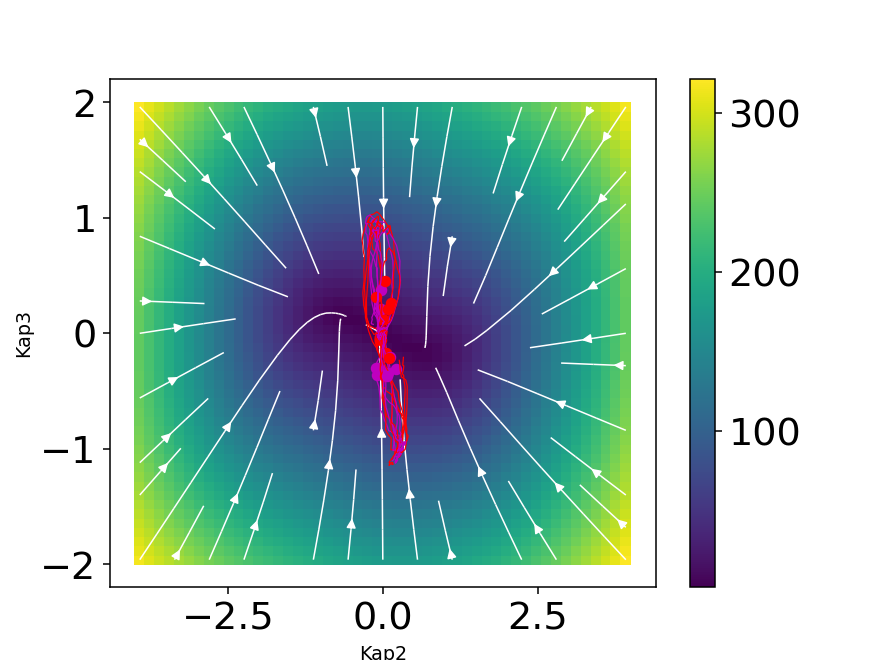

In [47]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
[ax, mappable] = ranktwo.plot_field(net_lo, m2, m3, -4, 4, -2, 2)
for i in range(kap1.shape[0]):
     plt.plot(kap2[i,:50], kap3[i,:50], color = 'red',linewidth=0.65)
     plt.plot(kapC2[i,:50], kapC3[i,:50], color = 'm',linewidth=0.65)
     plt.plot(kapC2[i,-1], kapC3[i,-1], '.', markersize = 10, color = 'm')
     plt.plot(kap2[i,-1], kap3[i,-1], '.', markersize = 10, color = 'red')

plt.xlabel('Kap2')
plt.ylabel('Kap3')
plt.colorbar(mappable)

# plt.savefig('TFinter.pdf', bbox_inches='tight')

plt.show()


In [20]:
# generate color interruption trials

inputs, off_time, allCoh, _ = TF.generate_interrupt_inputs(5, interrupt_type = 'checkerboard')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10
COn = 150
# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

(5, 211)

<IPython.core.display.Javascript object>


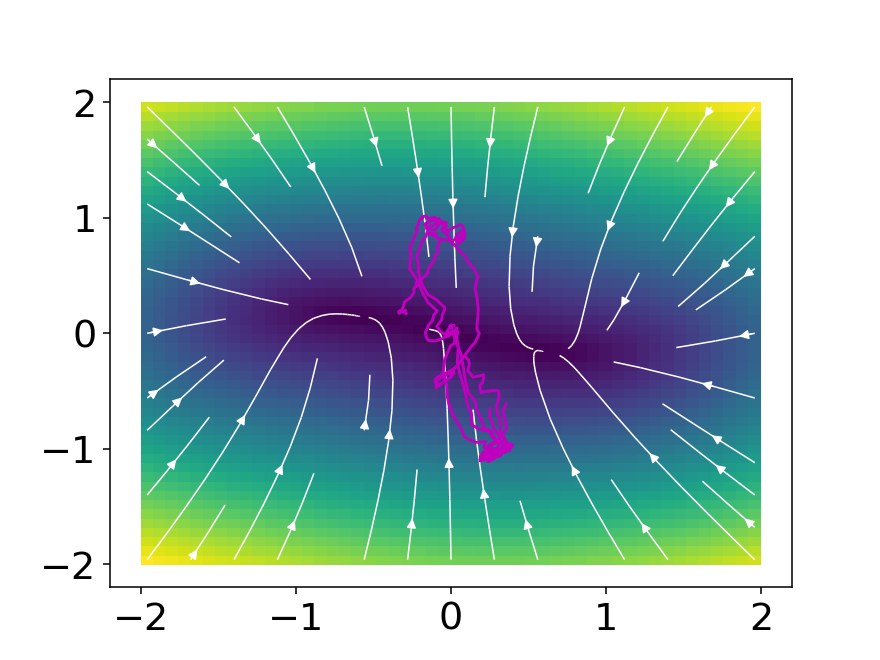

In [22]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m2, m3, -2, 2, -2, 2)
for i in range(kap1.shape[0]):
     plt.plot(kapC2[i,:100], kapC3[i,:100], color = 'm')
  
plt.show()

# TFD interrupt


In [16]:
# load a low-rank RNN

rank = 4
x_train, y_train, mask_train, cohAll_train, x_val, y_val, mask_val, cohAll_val = TFD.generate_checker_data(5000)

net_lo = LowRankRNN(3, size, 1, noise_std, alpha, rank=rank)
net_lo.load_state_dict(torch.load(f'../models/TFD_rank4_{size}.pt', map_location='cpu'))

loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

loss=0.042, acc=1.000


In [17]:
net_lo.svd_reparametrization()
wi1 = net_lo.wi[0].detach().numpy()
wi2 = net_lo.wi[1].detach().numpy()
wi3 = net_lo.wi[2].detach().numpy()
# n: low-rank Wrec connectivity vector n
n1 = net_lo.n[:, 0].detach().numpy()
n2 = net_lo.n[:, 1].detach().numpy()
n3 = net_lo.n[:, 2].detach().numpy()


# m: low-rank Wrec connectivity vector m
m1 = net_lo.m[:, 0].detach().numpy()
m2 = net_lo.m[:, 1].detach().numpy()
m3 = net_lo.m[:, 2].detach().numpy()


wo = net_lo.wo.detach().squeeze().numpy()

In [18]:
# 1st way to generate low-traj
loss, acc, out, decisions, target_decisions, traj = TFD.test_checker(net_lo, x_val, y_val, mask_val)
print(f'loss={loss:.3f}, acc={acc:.3f}')

traj1 = traj.detach().numpy()

decisions1 = decisions.detach().numpy()

tfRL = traj1[np.logical_and(decisions1 == -1, cohAll_val > 0),:,:]
tfRR = traj1[np.logical_and(decisions1 == 1, cohAll_val > 0),:,:]
tfGL = traj1[np.logical_and(decisions1 == -1, cohAll_val < 0),:,:]
tfGR = traj1[np.logical_and(decisions1 == 1, cohAll_val < 0),:,:]

trajLow = np.zeros((4, tfRL.shape[1], tfRL.shape[2]))
trajLow[0,:,:] = np.mean(tfRL,axis = 0)
trajLow[1,:,:] =np.mean(tfRR,axis = 0)
trajLow[2,:,:] =np.mean(tfGL,axis = 0)
trajLow[3,:,:] =np.mean(tfGR,axis = 0)

loss=0.044, acc=1.000


In [19]:

# project low rank rnn traj on m1 vector
kap1 = trajLow @ m1 / size
kap2 = trajLow @ m2 / size
kap3 = trajLow @ m3 / size
# kap4 = trajLow @ m4 / size

colors = ['red', 'red', 'green', 'green']
lineStyle = ['-', '--', '-', '--']
TOn = 10
COn = 160
TOff = 100

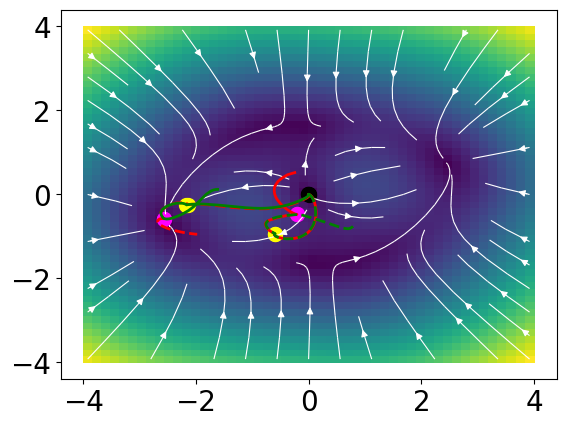

In [22]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m2, m3, -4, 4, -4, 4)
for i in range(4):
     plt.plot(kap2[i], kap3[i], c=colors[i], lw=2, ls=lineStyle[i])
     plt.scatter(kap2[i, TOn], kap3[i, TOn], c= 'black',
            marker='.', s=400)  
     plt.scatter(kap2[i, COn], kap3[i, COn], c= 'magenta',
            marker='.', s=400)  
     plt.scatter(kap2[i, TOff], kap3[i, TOff], c= 'yellow',
        marker='.', s=400)
    
plt.savefig('TFDtraj.pdf', bbox_inches='tight')
plt.show()



In [21]:
def generateinterrput(num_trials, interrupt_type): 
    # generate interrupt targets configuration inputs
    inputs, off_time, _, allContext = TFD.generate_interrupt_inputs(10, interrupt_type = 'targets')

    y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
    traj_inter1 = traj_inter.detach().numpy()
    off_time1 = off_time.detach().numpy()



    # project low rank rnn traj on m1 vector
    kap1 = traj_inter1 @ m1 / size
    kap2 = traj_inter1 @ m2 / size
    kap3 = traj_inter1 @ m3 / size
    
    return kap1, kap2, kap3

In [77]:
inputs, off_time, _, allContext = TFD.generate_interrupt_inputs(10, interrupt_type = 'targets')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10

# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

In [22]:
[kap1, kap2, kap3] = generateinterrput(10, 'targets')
[kapC1, kapC2, kapC3] = generateinterrput(10, 'checkerboard')


<IPython.core.display.Javascript object>


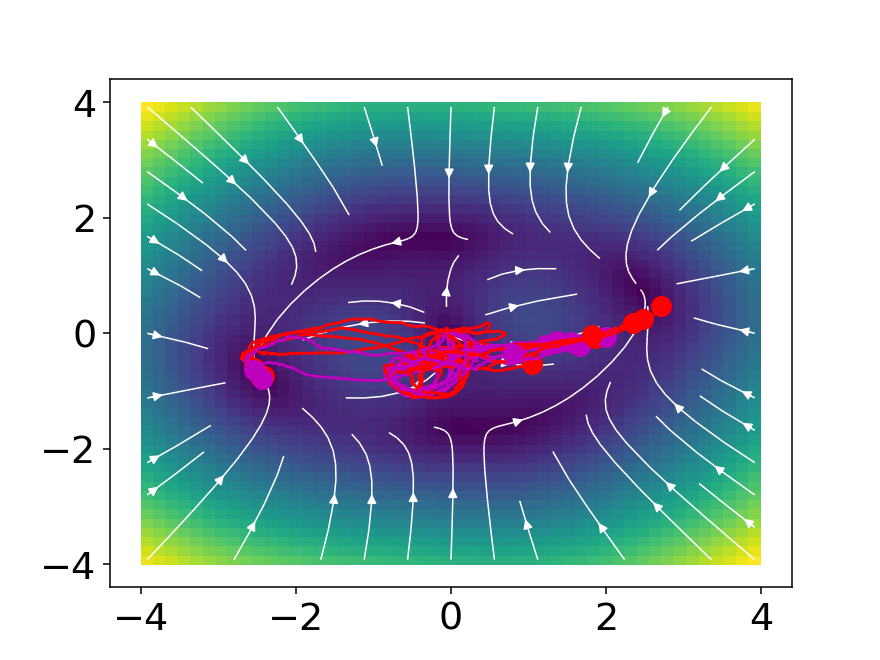

In [28]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m2, m3, -4, 4, -4, 4)
for i in range(kap1.shape[0]):
     plt.plot(kap2[i,:], kap3[i,:], color = 'red')
     plt.plot(kap2[i,-1], kap3[i,-1], '.', markersize = '20',color = 'r')
     plt.plot(kapC2[i,:], kapC3[i,:], color = 'm')
     plt.plot(kapC2[i,-1], kapC3[i,-1], '.', markersize = '20',color = 'm')        

plt.show()

# plt.savefig('TFDinter.pdf', bbox_inches='tight')

In [70]:
inputs, off_time, _, allContext = TFD.generate_interrupt_inputs(10, interrupt_type = 'checkerboard')

y_inter, traj_inter = net_lo.forward(inputs, return_dynamics = True)
traj_inter1 = traj_inter.detach().numpy()
off_time1 = off_time.detach().numpy()


TOn = 10

# project low rank rnn traj on m1 vector
kap1 = traj_inter1 @ m1 / size
kap2 = traj_inter1 @ m2 / size
kap3 = traj_inter1 @ m3 / size

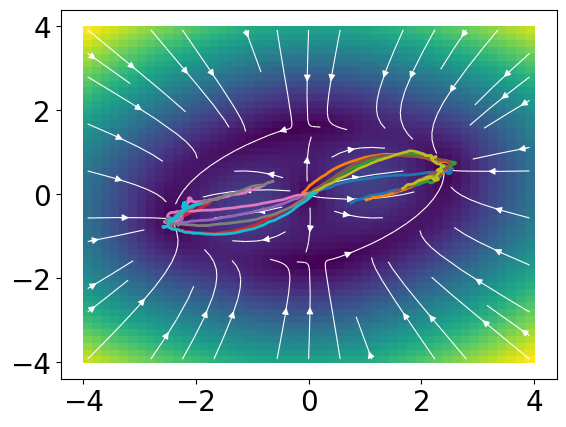

In [71]:
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
ranktwo.plot_field(net_lo, m1, m3, -4, 4, -4, 4)
for i in range(kap1.shape[0]):
     plt.plot(kap1[i,:], kap3[i,:], lw=2)

plt.show()